In [1]:
import torch
import os
import re
import sys
import cv2
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torch import nn
from scipy.ndimage.filters import gaussian_filter

In [2]:
from PoseEstimator.PoseEstimation import model, process_image, process_output

In [3]:
torch_device = torch.device('cuda:3')

In [4]:
model_pose = model(pretrained=True)
model_pose = model_pose.to(torch_device)
model_pose.eval() ;

In [5]:
image_path = './sample_image/b1.jpg'
output_path = './output/'

In [6]:
heatmap_avg, paf_avg, segm = process_image(model_pose, image_path, torch_device)

## Image

In [7]:
img = plt.imread(image_path)

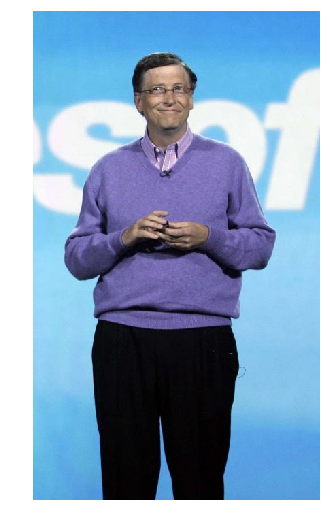

In [8]:
plt.figure(figsize=(9,9))
plt.imshow(img)
plt.axis('off')
plt.show()

## Skeleton

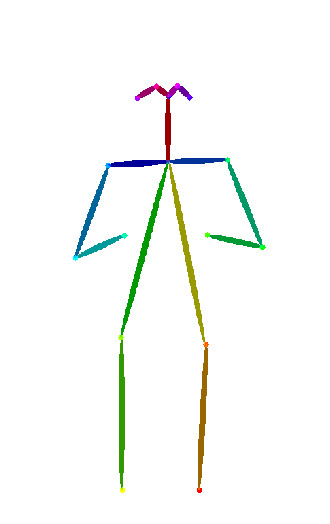

In [9]:
skeleton = process_output(heatmap_avg, paf_avg, image_path, skeleton=True)
skeleton = skeleton.astype(np.uint8)
b,g,r = cv2.split(skeleton)
skeleton = cv2.merge((r,g,b))
skeleton = np.dstack((skeleton, ((skeleton.sum(2)>0)*255)[:,:,None])).astype(np.uint8)
plt.imsave(output_path + 'skeleton.png', skeleton)

plt.figure(figsize=(9,9))
plt.imshow(skeleton)
plt.axis('off')
plt.show()

## Skeleton image

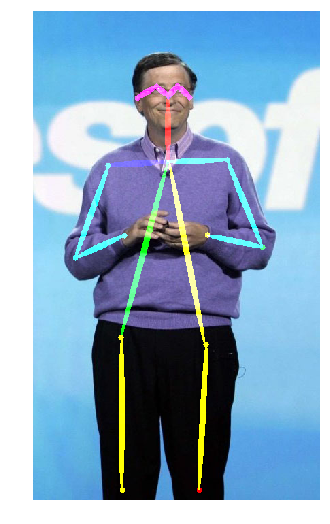

In [10]:
# image skeleton
img_skeleton = cv2.addWeighted(img, 1, skeleton[:,:,:3], 10, 0)
plt.imsave(output_path + 'image_skeleton.png', img_skeleton)

plt.figure(figsize=(9,9))
plt.imshow(img_skeleton)
plt.axis('off')
plt.show()

## Segmentation

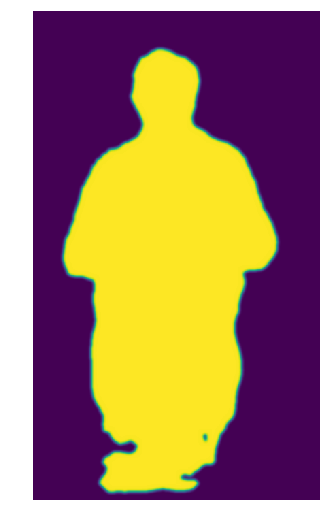

In [11]:
prediction = nn.Upsample((skeleton.shape[0], skeleton.shape[1]), mode='bilinear', align_corners=True)(segm)      
segmentation = nn.Softmax(dim=1)(prediction)[0,1].cpu().data.numpy()

segmentation = ((segmentation[:,:,None]>0.5)*255).astype(np.uint8)[:,:,0]
segmentation = gaussian_filter(segmentation, sigma=2)

plt.imsave(output_path + 'segmentation.png', segmentation)


plt.figure(figsize=(9,9))
plt.imshow(segmentation)
plt.axis('off')
plt.show()

## Image segmentation

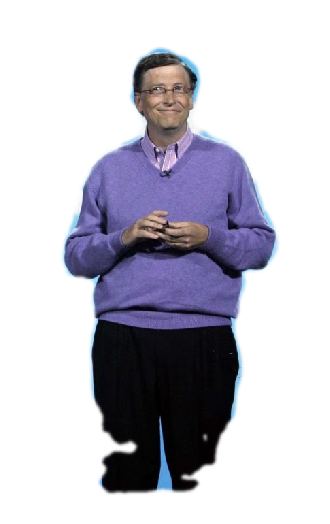

In [16]:
img_segm = np.dstack([img, segmentation])
plt.imsave(output_path + 'image_segmentation.png', img_segm)

plt.figure(figsize=(9,9))
plt.imshow(img_segm)
plt.axis('off')
plt.show()

## Skeleton segmantation

In [17]:
img_skeleton_segm = cv2.addWeighted(img_segm, 1, skeleton, 10, 0)
plt.imsave(output_path + 'image_segmentation_skeleton.png', img_skeleton_segm)

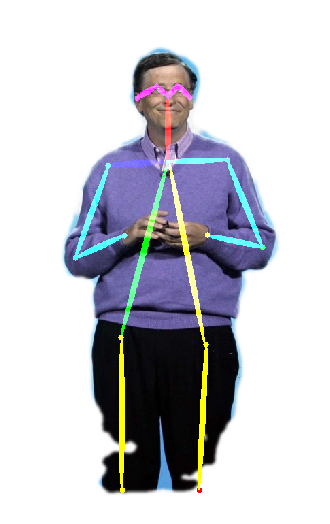

In [18]:
plt.figure(figsize=(9,9))
plt.imshow(img_skeleton_segm)
plt.axis('off')
plt.show()

## Skeleton mask

In [19]:
rgb_mask = cv2.cvtColor(segmentation, cv2.COLOR_GRAY2RGB)
rgb_mask = (rgb_mask > 0.5).astype(np.uint8)
rgb_mask[:,:,0]*= 255
rgb_mask[:,:,1]*= 0
rgb_mask[:,:,2]*= 0
rgb_mask = rgb_mask.astype(np.uint8)
mask_img = cv2.addWeighted(img_skeleton, 1, rgb_mask, 0.7, 0)



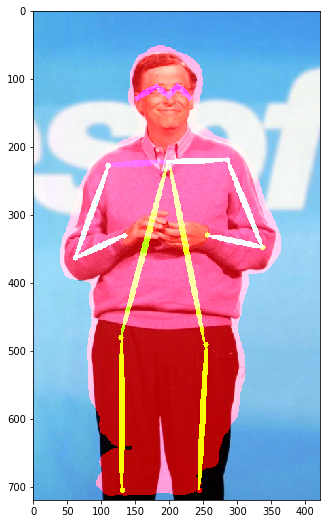

In [20]:
plt.figure(figsize=(9,9))
plt.imshow(mask_img)